In [771]:
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import adjusted_mutual_info_score
import numpy as np



import matplotlib.pyplot as plt
from Selfwritten_sklearn_modules.AddSentWeights import AddSentWeights

In [814]:
train = pd.read_csv("computer_subset_unannotated.csv")
sent_lex = pd.read_csv("WKWSCISentimentLexicon_v1.csv", sep='\t')

In [615]:
train.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,X,title,author,category,published_date,updated_on,slug,blurb,body,year,month
0,739,739,740,16248,"Watch 6,000 years of people moving to cities",Brian Resnick,The Latest,2016-06-19 13:20:03,2016-06-20 15:51:39,http://www.vox.com/2016/6/19/11955516/watch-60...,From the origin of the Fertile Crescent to the...,"['Humans', 'have', 'been', 'building', 'and', ...",2016,2016-06
1,276,276,277,3754,Why Paranormal Activity was one of the most su...,Alex Abad-Santos,Culture,2015-01-02 16:30:02,2015-01-02 16:30:02,http://www.vox.com/2015/1/2/7470985/most-profi...,What ultimately matters is how much a movie ma...,"['One', 'of', 'the', 'quickest', 'ways', 'to',...",2015,2015-01


In [616]:
sent_lex.describe()

,sentiment
count,29834.000000
mean,-0.182912
std,0.914229
min,-3.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


In [619]:
levels = np.asarray(sent_lex['sentiment'])
np.unique(levels)

array([-3., -2., -1.,  0.,  1.,  2.,  3.])

In [618]:
train_x = train['body'] #extract the text

sent_lex = sent_lex[['term','sentiment']] #drop the POS-column
sent_lex = sent_lex.drop_duplicates('term')

First approach is inspired by the one discussed in section 5 and 6 of this tutorial:
https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483

I'll write a custom transformer to link sentiment weights and word counts together, so I'm first testing the idea on a small playset.

In [604]:
playset = train_x.head(5)
terms = sent_lex['term'].tolist()
countvectorizer = CountVectorizer(vocabulary=terms)
playset_transformed = countvectorizer.fit_transform(playset)
sent_weights = AddSentWeights(sent_lex)
weighted_sents = sent_weights.transform(playset_transformed)
print(weighted_sents.shape)

(5, 28955)


Minibatch KMeans: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans 

This is a variant of KMeans that performs slightly worse than the normal KMeans, but is much faster.

We want three clusters: One for positive texts, one for negative texts, and one for neutral texts.

In [495]:
#fit_transform bugs with this pipeline, but fit and transform can be called separately, so I load the classifier separately
preprocessing = Pipeline([('counts', CountVectorizer(vocabulary=terms)),
                        ('sent_weights', AddSentWeights(df=sent_lex)),
                         ])
                        
minikmeans = MiniBatchKMeans(n_clusters = 3)

In [496]:
preprocessing.fit(train_x)

Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None,
                                 vocabulary=[...
                                             'abate', 'abatement', 'abattoir',
                                             'abbess', 'abbey', 'abbot',
                                             'abbr.', 'abbreviate',
                                             'abbreviation', 'abdicate',
          

In [497]:
transformed_train_x = preprocessing.transform(train_x)

In [498]:
cluster = minikmeans.fit_predict(transformed_train_x)

In [499]:
samples = minikmeans.transform(transformed_train_x)
cluster = cluster.reshape(1023,1)

samples_rescaled = np.multiply(cluster + 1, samples)

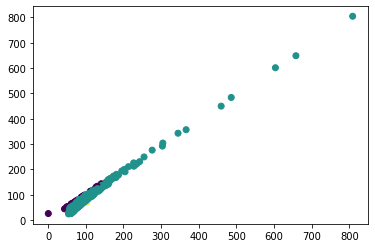

In [501]:
plt.scatter(samples_rescaled[:,0], samples_rescaled[:,1], c=cluster)

Ok, the algorithm seemed to have worked, but not very well. There is a large group around the (0,4.5)-point. Let's play around with the reassignment ratio.

In [502]:
minikmeans = MiniBatchKMeans(n_clusters = 3, reassignment_ratio = 0.9)

In [503]:
cluster = minikmeans.fit_predict(transformed_train_x)

In [506]:
samples = minikmeans.transform(transformed_train_x)
cluster = cluster.reshape(1023,1)

samples_rescaled = np.multiply(cluster + 1, samples)

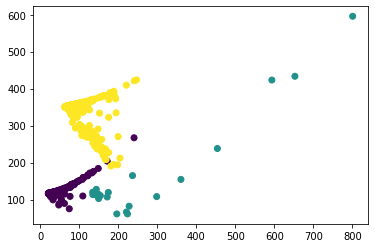

In [507]:
plt.scatter(samples_rescaled[:,0], samples_rescaled[:,1], c=cluster)

Let's try TfidfVectorizer instead of CountVectorizer

In [798]:
preprocessing = Pipeline([('counts', TfidfVectorizer(vocabulary=terms)),
                        ('sent_weights', AddSentWeights(df=sent_lex)),
                         ])
                        

In [799]:
preprocessing.fit(train_x)

transformed_train_x = preprocessing.transform(train_x)

In [800]:
minikmeans = MiniBatchKMeans(n_clusters = 3, reassignment_ratio = 0.9)

In [801]:
cluster = minikmeans.fit_predict(transformed_train_x)

In [803]:
samples = minikmeans.transform(transformed_train_x)
cluster = cluster.reshape(1023,1)

samples_rescaled = np.multiply(cluster + 1, samples)

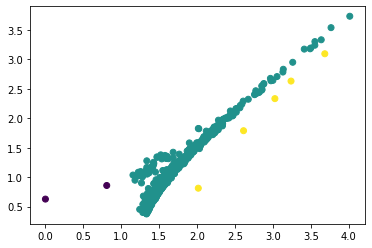

In [804]:
plt.scatter(samples_rescaled[:,0], samples_rescaled[:,1], c=cluster)

That doesn't seem to work as good as the last model. Therefore, I evaluate the following model:

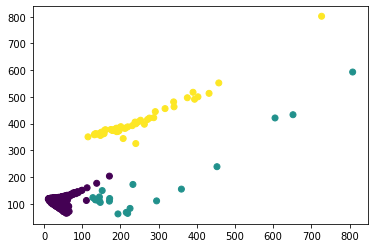

In [805]:
preprocessing = Pipeline([('counts', CountVectorizer(vocabulary=terms)),
                        ('sent_weights', AddSentWeights(df=sent_lex)),
                         ])
                        
minikmeans = MiniBatchKMeans(n_clusters = 3, reassignment_ratio=0.9)
preprocessing.fit(train_x)
transformed_train_x = preprocessing.transform(train_x)
cluster = minikmeans.fit_predict(transformed_train_x)

samples = minikmeans.transform(transformed_train_x)
cluster = cluster.reshape(1023,1)

samples_rescaled = np.multiply(cluster + 1, samples)


plt.scatter(samples_rescaled[:,0], samples_rescaled[:,1], c=cluster)

**Evaluation**

Adjusted Mutual Information score according to https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

- score ranges from 0 to 1

1: kmeans and our annotations agree significantly

0: kmeans and we disagree strongly on this label


In [836]:
diana = pd.read_csv('computer_subset_annotate_diana.csv')

In [837]:
edward = pd.read_csv('computer_subset_annotate_edward.csv',sep=';')

In [857]:
diana = diana.dropna()
diana_x = diana['body']
diana_y = diana['sentiment']

edward = edward.dropna()
edward_x = edward['body']
edward_y = edward['sentiment']

In [858]:
len(edward)

58

In [859]:
len(diana_y)

60

In [860]:
labels = cluster.reshape(1,1023)

In [812]:
np.unique(labels)

array([0, 1, 2], dtype=int32)

Finding out which label belongs to which sentiment by clustering positive, and negative words from the sentiment lexikon:

In [815]:
levels = np.asarray(sent_lex['sentiment'])
np.unique(levels)

array([-3., -2., -1.,  0.,  1.,  2.,  3.])

In [816]:
pos_sent = sent_lex[sent_lex.sentiment == 3].dropna()
neut_sent = sent_lex[sent_lex.sentiment == 0].dropna()
neg_sent = sent_lex[sent_lex.sentiment == -3].dropna()

In [817]:
pos_sent['term'] = (pos_sent.term + ',') * 1000

neut_sent['term'] = (neut_sent.term + ',') * 1000

neg_sent['term'] = (neg_sent.term + ',') * 1000

In [831]:
pos_sent_x = preprocessing.transform(pos_sent['term'].dropna())
pos_sent_label = minikmeans.predict(pos_sent_x)

neut_sent_x = preprocessing.transform(neut_sent['term'].dropna())
neut_sent_label = minikmeans.predict(neut_sent_x)

neg_sent_x = preprocessing.transform(neg_sent['term'].dropna())
neg_sent_label = minikmeans.predict(neg_sent_x)

In [832]:
np.unique(neg_sent_label, return_counts=True)

(array([0, 2], dtype=int32), array([69,  1]))

In [823]:
np.unique(pos_sent_label, return_counts=True)

(array([0, 1, 2], dtype=int32), array([99,  1, 15]))

In [824]:
np.unique(neut_sent_label, return_counts=True)

(array([0, 1, 2], dtype=int32), array([19370,     3,    24]))

According to the results: 0=negative, 2=neutral, 1=positive)

In [862]:
for i in range(0,len(edward_y) + 2): #He has some NAs in his data frame
    try:
        if edward_y[i] == 'negative':
            edward_y[i] = 0
        elif edward_y[i] == 'neutral':
            edward_y[i] = 2
        elif edward_y[i] == 'positive':
            edward_y[i] = 1
    except KeyError:
        
        continue

/Users/dianaenggist/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [842]:
len(edward_y)

58

In [843]:
for i in range(0,len(diana_y)):
    if diana_y[i] == 'negative':
        diana_y[i] = 0
    elif diana_y[i] == 'neutral':
        diana_y[i] = 2
    elif diana_y[i] == 'positive':
        diana_y[i] = 1

/Users/dianaenggist/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/dianaenggist/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/dianaenggist/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate fr

In [844]:
diana_x = preprocessing.transform(diana_x)
edward_x = preprocessing.transform(edward_x)

In [845]:
diana_labels = minikmeans.predict(diana_x)

In [846]:
edward_labels = minikmeans.predict(edward_x)

In [851]:
diana_y = diana_y.astype(int)
ami_diana = adjusted_mutual_info_score(diana_y, diana_labels)

In [852]:
print(ami_diana)

-0.005688353498231638


In [864]:
edward_y = edward_y.astype(int)
ami_edward = adjusted_mutual_info_score(edward_y, edward_labels)

In [865]:
print(ami_edward)

-1.828408844426632e-15


**Distribution over time**

In [884]:
date = train['month']

cluster_df = pd.DataFrame(cluster.reshape(1023,1))

df_time_matrix = pd.merge(train['month'], cluster_df, left_index=True, right_index=True)


In [895]:
#I drop this to a .csv-file, and plot it in R
df_time_matrix.to_csv('time_matrix.csv')